Species Classification

0-funestus 1-gambiae 2-Anopheles_other 3-culex 4-All other

Author: Remus

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import re

# Read and export data from M1

In [ ]:
REBUILD_DATA = False

fileNameStr='Master Data Sheet Organization.xlsx'
data_df = pd.read_excel(fileNameStr)

In [ ]:
new_header = data_df.iloc[0] #grab the first row for the header
data_df = data_df[1:] #take the data less the header row
data_df.columns = new_header #set the header row as the df header
data_df.shape

(1722, 18)

In [ ]:
data_df = data_df.loc[(data_df['Picture?'] == 'Y')].reset_index(drop=True)

In [ ]:
data_df.shape

(1409, 18)

In [ ]:
df_a = data_df[(data_df['Morph ID Genus'] == 'Anopheles') | (data_df['Morph ID Genus'] == 'anopheles') | (data_df['Morph ID Genus'] == 'Anopheles ')]
print(df_a.shape)
df_b = data_df[(data_df['Morph ID Genus'] == 'Culex')]
print(df_b.shape)
df_c = data_df[(data_df['Morph ID Genus'] != 'Culex') & (data_df['Morph ID Genus'] != 'Anopheles') & (data_df['Morph ID Genus'] != 'anopheles')& (data_df['Morph ID Genus'] != 'Anopheles ')]
print(df_c.shape)

(1000, 18)
(224, 18)
(185, 18)


In [ ]:
# use PCR results if avaliable
df = pd.DataFrame()
ID = []
genus = []
species = []
for i in range(data_df.shape[0]):
    ID.append(data_df.loc[i,'MOSQUITO ID (Team)'])
    genus_name = data_df.loc[i,'Morph ID Genus']
    species_name = data_df.loc[i,'Morph ID Species']
    if pd.notna(data_df.loc[i,'PCR ID Genus']) == True:
        genus_name = data_df.loc[i,'PCR ID Genus']
    if pd.notna(data_df.loc[i,'PCR ID Species']) == True:
        species_name = data_df.loc[i,'PCR ID Species']
    genus.append(genus_name)
    species.append(species_name)
df['ID'] = ID
df['genus'] = genus
df['species'] = species
df = df.dropna(subset=['genus'],how='any').reset_index(drop=True)
df

,ID,genus,species
0,U-SR-01-0006,Anopheles,funestus
1,U-SR-01-0008,Anopheles,funestus
2,U-SR-01-0009,Anopheles,funestus
3,U-SR-01-0010,Anopheles,funestus
4,U-SR-01-0011,Anopheles,funestus
...,...,...,...
1369,Z-MA-01-0295,Anopheles,gambiae
1370,Z-MA-01-0296,Anopheles,gambiae
1371,Z-MA-01-0297,Anopheles,rufipes
1372,Z-MA-01-0298,Anopheles,Longipalps


In [ ]:
print(df[df['ID'] == 'U-SR-02-0042'])

               ID      genus   species
517  U-SR-02-0042  Anopheles  funestus


In [ ]:
print(df[df['ID'] == 'G-TM-04-0107'])

               ID   genus species
960  G-TM-04-0107  Culex      NaN


In [ ]:
df_with_label = pd.DataFrame()
label = []
for i in range(df.shape[0]):
    genus = df.loc[i,'genus']
    species = df.loc[i,'species']
    if genus == 'Anopheles' or genus == 'anopheles' or genus == 'Anopheles ':
        if species == 'funestus':
            label.append(0)
        elif species == 'gambiae' or species == 'Gambiae' or species == 'gambie':
            label.append(1)
        else:
            label.append(2)
    elif genus == "Culex" or genus == "Culex ":
        label.append(3)
    else:
        label.append(4)
        
df_with_label['ID'] = df['ID']
df_with_label['label'] = label
df_with_label

,ID,label
0,U-SR-01-0006,0
1,U-SR-01-0008,0
2,U-SR-01-0009,0
3,U-SR-01-0010,0
4,U-SR-01-0011,0
...,...,...
1369,Z-MA-01-0295,1
1370,Z-MA-01-0296,1
1371,Z-MA-01-0297,2
1372,Z-MA-01-0298,2


In [ ]:
df1 = df_with_label[df_with_label['label'] == 0]
df2 = df_with_label[df_with_label['label'] == 1]
df3 = df_with_label[df_with_label['label'] == 2]
df4 = df_with_label[df_with_label['label'] == 3]
df5 = df_with_label[df_with_label['label'] == 4]
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(457, 2)
(236, 2)
(330, 2)
(328, 2)
(23, 2)


In [ ]:
df3

,ID,label
88,U-SR-01-0124,2
441,U-SR-01-0632,2
442,U-SR-01-0633,2
444,U-SR-01-0635,2
452,U-SR-01-0701,2
...,...,...
1367,Z-MA-01-0293,2
1368,Z-MA-01-0294,2
1371,Z-MA-01-0297,2
1372,Z-MA-01-0298,2


In [ ]:
print(df_with_label[df_with_label['ID'] == 'G-TM-02-0108'])

               ID  label
719  G-TM-02-0108      2


In [ ]:
df1 = df1.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = df3.sample(frac=1).reset_index(drop=True)
df4 = df4.sample(frac=1).reset_index(drop=True)
df5 = df5.sample(frac=1).reset_index(drop=True)
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(457, 2)
(236, 2)
(330, 2)
(328, 2)
(23, 2)


In [ ]:
from sklearn.model_selection import train_test_split
train_data1, test_data1 = train_test_split(df1, test_size=0.2)
train_data2, test_data2 = train_test_split(df2, test_size=0.2)
train_data3, test_data3 = train_test_split(df3, test_size=0.2)
train_data4, test_data4 = train_test_split(df4, test_size=0.2)
train_data5, test_data5 = train_test_split(df5, test_size=0.2)

In [ ]:
train_data = pd.concat([train_data1, train_data2, train_data3, train_data4, train_data5], ignore_index=True)
test_data = pd.concat([test_data1, test_data2, test_data3, test_data4, test_data5], ignore_index=True)
print(train_data.shape)
print(test_data.shape)
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

(1097, 2)
(277, 2)


In [ ]:
test_data.head()

,ID,label
0,U-SR-01-0471,1
1,U-SR-01-0069,0
2,Z-MA-01-0083,1
3,G-TM-02-0058,3
4,Z-MA-01-0127,2


In [ ]:
train_data.to_csv('species/data/train_path_3_1.csv', index = False)

In [ ]:
from torchvision import transforms
mosquito_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize([299,299]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
from PIL import Image, ImageOps
def make_data(d):
    data_path = "Mosquito_Database_Rev2"
    data = []
    label = []
    paths = []
    F_count = 0
    G_count = 0
    Aother_count = 0
    C_count = 0
    Other_count = 0
    df = pd.DataFrame()
    for i in range(d.shape[0]):
        for f in os.listdir(data_path):
            if re.match(d.loc[i,'ID'], f) and f.endswith('a.jpg'):
                path = os.path.join(data_path, f)
                paths.append(path)
                image = Image.open(path)
                image = ImageOps.exif_transpose(image)
                image = mosquito_transforms(image)
                data.append(image)
                if d.loc[i,'label'] == 0:
                    label.append(0)
                    F_count += 1
                elif d.loc[i,'label'] == 1:
                    label.append(1)
                    G_count += 1
                elif d.loc[i,'label'] == 2:
                    label.append(2)
                    Aother_count += 1    
                elif d.loc[i,'label'] == 3:
                    label.append(3)
                    C_count += 1
                elif d.loc[i,'label'] == 4:
                    label.append(4)
                    Other_count += 1
    stacked_data = torch.stack(data)
    df['path'] = paths
    df['label'] = label                   
                
    return stacked_data, label, df, F_count, G_count, Aother_count, C_count, Other_count 

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle = True)
target = train_data.loc[:,'label']
count = 1
for train_index, valid_index in skf.split(train_data, target):
    train = train_data.loc[train_index,:]
    valid = train_data.loc[valid_index,:]
    train = train.reset_index(drop=True)
    valid = valid.reset_index(drop=True)
    d, label, path_df, f_count, g_count, Aother_count, c_count, other_count = make_data(valid)
    torch.save(d,f"species/data/valid_data_fold{count}.pt")
    torch.save(torch.tensor(label),f"species/data/valid_label_fold{count}.pt")
    path_df.to_csv(f"species/data/valid_datapath_fold{count}.csv", index = False)
    d2, label2, path_df2, train_f_count, train_g_count, train_Aother_count, train_c_count, train_other_count = make_data(train)
    torch.save(d2,f"species/data/train_data_fold{count}.pt")
    torch.save(torch.tensor(label2),f"species/data/train_label_fold{count}.pt")
    path_df2.to_csv(f"species/data/train_datapath_fold{count}.csv", index = False)
    count += 1
    print("valid counts:", "AF:", f_count, "AG:", g_count, "A_other:", Aother_count, "Culex:", c_count, "Other:", other_count)
    print("train counts:", "AF:", train_f_count, "AG:", train_g_count, "A_other:", train_Aother_count, "Culex:", train_c_count, "Other:", train_other_count)

valid counts: AF: 215 AG: 69 A_other: 81 Culex: 199 Other: 11
train counts: AF: 845 AG: 346 A_other: 412 Culex: 668 Other: 41
valid counts: AF: 210 AG: 75 A_other: 112 Culex: 159 Other: 11
train counts: AF: 850 AG: 340 A_other: 381 Culex: 708 Other: 41
valid counts: AF: 212 AG: 93 A_other: 94 Culex: 206 Other: 9
train counts: AF: 848 AG: 322 A_other: 399 Culex: 661 Other: 43
valid counts: AF: 211 AG: 112 A_other: 115 Culex: 151 Other: 9
train counts: AF: 849 AG: 303 A_other: 378 Culex: 716 Other: 43
valid counts: AF: 212 AG: 66 A_other: 91 Culex: 152 Other: 12
train counts: AF: 848 AG: 349 A_other: 402 Culex: 715 Other: 40


In [ ]:
d, label, path_df, f_count, g_count, Aother_count, c_count, other_count = make_data(train_data)

In [ ]:
print(d.shape)
print(f_count)
print(g_count)
print(Aother_count)
print(c_count)
print(other_count)

torch.Size([1549, 3, 299, 299])
595
225
277
410
42


In [ ]:
path_df.to_csv('species/data/train_path3_2.csv', index = False)

In [ ]:
print('Test min=%.3f, max=%.3f' % (np.array(d).min(), np.array(d).max()))

Test min=-2.118, max=2.640


In [ ]:
torch.save(d,"species/data/Species_train_data3_2.pt")
torch.save(torch.tensor(label),"species/data/Species_train_label3_2.pt")

# Read and export from M2

In [ ]:
fileNameStr='Zambia_VectorCam Image Collection Form-hh_repeat.csv'
data_df = pd.read_csv(fileNameStr)

In [ ]:
data_df.drop(data_df[data_df['specimen_characteristics'] == "O"].index, inplace = True)

In [ ]:
data_df.reset_index(drop=True, inplace=True)
data_df.shape

(424, 25)

In [ ]:
label = []
for i in range(data_df.shape[0]):
    genus = data_df.loc[i,'morph_id_genus']
    species = data_df.loc[i,'morph_id_anopheles_species']
    if genus == 'Anopheles' or genus == 'anopheles' or genus == 'Anopheles ':
        if species == 'funestus':
            label.append(0)
        elif species == 'gambiae' or species == 'Gambiae' or species == 'gambie':
            label.append(1)
        else:
            label.append(2)
    elif genus == "Culex" or genus == "culex ":
        label.append(3)
    else:
        label.append(4)
data_df["label"] = label

In [ ]:
df1 = data_df[data_df['label'] == 0]
df2 = data_df[data_df['label'] == 1]
df3 = data_df[data_df['label'] == 2]
df4 = data_df[data_df['label'] == 3]
#df5 = data_df[data_df['label'] == 4]
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
#print(df5.shape)

(228, 26)
(65, 26)
(34, 26)
(97, 26)
(0, 26)


In [ ]:
df1 = df1.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = df3.sample(frac=1).reset_index(drop=True)
df4 = df4.sample(frac=1).reset_index(drop=True)
#df5 = df5.sample(frac=1).reset_index(drop=True)
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(228, 26)
(65, 26)
(34, 26)
(97, 26)


In [ ]:
from sklearn.model_selection import train_test_split
train_data1, test_data1 = train_test_split(df1, test_size=0.2)
train_data2, test_data2 = train_test_split(df2, test_size=0.2)
train_data3, test_data3 = train_test_split(df3, test_size=0.2)
train_data4, test_data4 = train_test_split(df4, test_size=0.2)
#train_data5, test_data5 = train_test_split(df5, test_size=0.2)

In [ ]:
train_data = pd.concat([train_data1, train_data2, train_data3, train_data4], ignore_index=True)
test_data = pd.concat([test_data1, test_data2, test_data3, test_data4], ignore_index=True)
print(train_data.shape)
print(test_data.shape)
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

(338, 26)
(86, 26)


In [ ]:
from torchvision import transforms
mosquito_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize([299,299]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
from PIL import Image, ImageOps
def make_new_data(d):
    data_path = "media"
    data = []
    label = []
    paths = []
    F_count = 0
    G_count = 0
    Aother_count = 0
    C_count = 0
    Other_count = 0
    df = pd.DataFrame()
    for i in range(d.shape[0]):
        list_specimen = []
        list_specimen.append(d.loc[i,'specimen_image_1'])
        list_specimen.append(d.loc[i,'specimen_image_2'])
        list_specimen.append(d.loc[i,'specimen_image_3'])
        for specimen in list_specimen:
            if specimen in os.listdir(data_path):
                path = os.path.join(data_path, specimen)
                paths.append(path)
                image = Image.open(path)
                #image = ImageOps.exif_transpose(image)
                image = mosquito_transforms(image)
                data.append(image)
                if d.loc[i,'label'] == 0:
                    label.append(0)
                    F_count += 1
                elif d.loc[i,'label'] == 1:
                    label.append(1)
                    G_count += 1
                elif d.loc[i,'label'] == 2:
                    label.append(2)
                    Aother_count += 1    
                elif d.loc[i,'label'] == 3:
                    label.append(3)
                    C_count += 1
                elif d.loc[i,'label'] == 4:
                    label.append(4)
                    Other_count += 1
    stacked_data = torch.stack(data)
    df['path'] = paths
    df['label'] = label                   
                
    return stacked_data, label, df, F_count, G_count, Aother_count, C_count, Other_count 

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle = True)
target = train_data.loc[:,'label']
count = 1
for train_index, valid_index in skf.split(train_data, target):
    train = train_data.loc[train_index,:]
    valid = train_data.loc[valid_index,:]
    train = train.reset_index(drop=True)
    valid = valid.reset_index(drop=True)
    d, label, path_df, f_count, g_count, Aother_count, c_count, other_count = make_new_data(valid)
    torch.save(d,f"species/data/valid_new_data_fold{count}.pt")
    torch.save(torch.tensor(label),f"species/data/valid_new_label_fold{count}.pt")
    path_df.to_csv(f"species/data/valid_new_datapath_fold{count}.csv", index = False)
    d2, label2, path_df2, train_f_count, train_g_count, train_Aother_count, train_c_count, train_other_count = make_new_data(train)
    torch.save(d2,f"species/data/train_new_data_fold{count}.pt")
    torch.save(torch.tensor(label2),f"species/data/train_new_label_fold{count}.pt")
    path_df2.to_csv(f"species/data/train_new_datapath_fold{count}.csv", index = False)
    count += 1
    print("valid counts:", "AF:", f_count, "AG:", g_count, "A_other:", Aother_count, "Culex:", c_count, "Other:", other_count)
    print("train counts:", "AF:", train_f_count, "AG:", train_g_count, "A_other:", train_Aother_count, "Culex:", train_c_count, "Other:", train_other_count)

valid counts: AF: 111 AG: 33 A_other: 15 Culex: 45 Other: 0
train counts: AF: 435 AG: 123 A_other: 66 Culex: 186 Other: 0
valid counts: AF: 111 AG: 30 A_other: 18 Culex: 45 Other: 0
train counts: AF: 435 AG: 126 A_other: 63 Culex: 186 Other: 0
valid counts: AF: 108 AG: 30 A_other: 18 Culex: 48 Other: 0
train counts: AF: 438 AG: 126 A_other: 63 Culex: 183 Other: 0
valid counts: AF: 108 AG: 30 A_other: 15 Culex: 48 Other: 0
train counts: AF: 438 AG: 126 A_other: 66 Culex: 183 Other: 0
valid counts: AF: 108 AG: 33 A_other: 15 Culex: 45 Other: 0
train counts: AF: 438 AG: 123 A_other: 66 Culex: 186 Other: 0


In [ ]:
d, label, path_df, f_count, g_count, Aother_count, c_count, other_count = make_new_data(test_data)

In [ ]:
print(d.shape)
print(f_count)
print(g_count)
print(Aother_count)
print(c_count)
print(other_count)

torch.Size([258, 3, 299, 299])
138
39
21
60
0


In [ ]:
path_df.to_csv('species/data/test_new_path.csv', index = False)

In [ ]:
print('Test min=%.3f, max=%.3f' % (np.array(d).min(), np.array(d).max()))

Test min=-2.015, max=2.379


In [ ]:
torch.save(d,"species/data/test_new_data.pt")
torch.save(torch.tensor(label),"species/data/test_new_label.pt")

# Read all data

In [ ]:
# if train
# new_data means part of data from March trip
# other_data means data from older large database taken with DLSR camera
# because we have so few image in "other" class. We can ignore them for now.
train_data = torch.load("species/data/train_data_fold2.pt")
train_label = torch.load("species/data/train_label_fold2.pt")
test_data = torch.load("species/data/valid_data_fold2.pt")
test_label = torch.load("species/data/valid_label_fold2.pt")
train_new_data = torch.load("species/data/train_new_data_fold2.pt")
train_new_label = torch.load("species/data/train_new_label_fold2.pt")
test_new_data = torch.load("species/data/valid_new_data_fold2.pt")
test_new_label = torch.load("species/data/valid_new_label_fold2.pt")
train_other_data = torch.load("species/data/train_other_data.pt")
train_other_label = torch.load("species/data/train_other_label.pt")
test_other_data = torch.load("species/data/test_other_data.pt")
test_other_label = torch.load("species/data/test_other_label.pt")

In [ ]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)
print(train_new_data.shape)
print(train_new_label.shape)
print(test_new_data.shape)
print(test_new_label.shape)
print(train_other_data.shape)
print(train_other_label.shape)
print(test_other_data.shape)
print(test_other_label.shape)

torch.Size([2320, 3, 299, 299])
torch.Size([2320])
torch.Size([567, 3, 299, 299])
torch.Size([567])
torch.Size([810, 3, 299, 299])
torch.Size([810])
torch.Size([204, 3, 299, 299])
torch.Size([204])
torch.Size([284, 3, 299, 299])
torch.Size([284])
torch.Size([55, 3, 299, 299])
torch.Size([55])


In [ ]:
# if test
test_data = torch.load("species/data/Species_test_data2.pt")
test_label = torch.load("species/data/Species_test_label2.pt")
test_new_data = torch.load("species/data/test_new_data.pt")
test_new_label = torch.load("species/data/test_new_label.pt")
test_other_data = torch.load("species/data/test_other_data.pt")
test_other_label = torch.load("species/data/test_other_label.pt")

In [ ]:
train_data = torch.cat((train_data, train_new_data, train_other_data), 0)
print(train_data.shape)

torch.Size([3414, 3, 299, 299])


In [ ]:
#train_label = torch.cat((train_label, train_new_label, train_other_label), 0)
test_data = torch.cat((test_data, test_new_data, test_other_data), 0)
test_label = torch.cat((test_label, test_new_label, test_other_label), 0)

In [ ]:
print(test_data.shape)

torch.Size([1042, 3, 299, 299])


In [ ]:
torch.save(train_data,"species/data/train_whole_data_fold2.pt")
torch.save(train_label,"species/data/train_whole_label_fold2.pt")
torch.save(test_data,"species/data/val_whole_data_fold2.pt")
torch.save(test_label,"species/data/val_whole_label_fold2.pt")

# Train and test 

In [ ]:
train_data = torch.load("species/data/train_whole_data_fold2.pt")
train_label = torch.load("species/data/train_whole_label_fold2.pt")
test_data = torch.load("species/data/val_whole_data_fold2.pt")
test_label = torch.load("species/data/val_whole_label_fold2.pt")

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print ("running on the GPU")
else:
    device = torch.device("cpu")
    print ("running on the cpu")

running on the GPU


In [ ]:
from torch.utils.data import Dataset


class VectorCamDataset(Dataset):
    
    
    def __init__(self, data, labels, transform=None):
        'Initialization'
        self.labels = labels
        self.data = data
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        
        'Generates one sample of data'

        # Load data and get label
        x = self.data[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)

        return x, y

In [ ]:
from torchvision import transforms
invTrans = transforms.Compose([ 
                                transforms.RandomHorizontalFlip(p=0.25),
                                transforms.RandomVerticalFlip(p=0.25)
                                #transforms.Normalize(mean = [ 0.5150, 0.7373, 1.1327 ],
                                #                     std = [ 0.5055, 0.4621, 0.4949 ]),
    
                               ])

In [ ]:
#train_dataset=VectorCamDataset(train_data,train_label,transform=invTrans)
test_dataset=VectorCamDataset(test_data,test_label)

In [ ]:
x, y = train_dataset[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


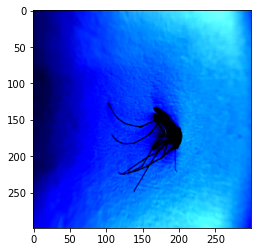

In [ ]:
plt.imshow(torch.permute(x, (1, 2, 0)))

In [ ]:
from torch.utils.data import DataLoader,WeightedRandomSampler

target_list = torch.tensor(train_dataset.labels)
class_count = np.array([len(np.where(train_dataset.labels == t)[0]) for t in np.unique(train_dataset.labels)])
print(class_count)
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(class_weights)
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )

[1285  466  444  894  325]
tensor([0.0008, 0.0021, 0.0023, 0.0011, 0.0031])


<ipython-input-10-48237969a9b6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_list = torch.tensor(train_dataset.labels)


In [ ]:
from torch.utils.data import DataLoader
#train_dataloader = DataLoader(train_dataset,sampler=weighted_sampler, batch_size = 32)
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle=False)

In [ ]:
for i, (data, target) in enumerate(train_dataloader):
    print("batch index {}, 0/1: {}/{}/{}/{}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0]),
        len(np.where(target.numpy() == 2)[0]),
        len(np.where(target.numpy() == 3)[0]),
        len(np.where(target.numpy() == 4)[0])))

batch index 0, 0/1: 0/8/12/8/4
batch index 1, 0/1: 6/10/5/7/4
batch index 2, 0/1: 5/8/3/11/5
batch index 3, 0/1: 10/4/3/9/6
batch index 4, 0/1: 6/7/7/7/5
batch index 5, 0/1: 8/7/7/4/6
batch index 6, 0/1: 8/6/7/4/7
batch index 7, 0/1: 8/5/5/6/8
batch index 8, 0/1: 7/6/5/7/7
batch index 9, 0/1: 7/8/7/4/6
batch index 10, 0/1: 5/9/3/6/9
batch index 11, 0/1: 6/5/4/7/10
batch index 12, 0/1: 4/7/10/7/4
batch index 13, 0/1: 5/10/10/2/5
batch index 14, 0/1: 5/8/8/4/7
batch index 15, 0/1: 9/7/6/4/6
batch index 16, 0/1: 10/5/5/5/7
batch index 17, 0/1: 5/10/6/5/6
batch index 18, 0/1: 8/9/4/5/6
batch index 19, 0/1: 8/6/5/8/5
batch index 20, 0/1: 6/8/6/6/6
batch index 21, 0/1: 7/6/8/4/7
batch index 22, 0/1: 8/8/3/6/7
batch index 23, 0/1: 7/5/7/6/7
batch index 24, 0/1: 7/4/6/9/6
batch index 25, 0/1: 11/3/4/8/6
batch index 26, 0/1: 7/7/4/7/7
batch index 27, 0/1: 6/10/6/6/4
batch index 28, 0/1: 10/8/5/3/6
batch index 29, 0/1: 5/8/11/6/2
batch index 30, 0/1: 5/8/6/7/6
batch index 31, 0/1: 8/5/6/9/4
batc

In [ ]:
from torchvision import models
model = models.inception_v3(pretrained=False)
model.fc = nn.Linear(2048, 5)
model.AuxLogits.fc = nn.Linear(768, 5)
model.load_state_dict(torch.load('species/models/Species_Inception_fold2_3_with_augmentation.pt'))
model = model.to(device)

D:\anaconda3\lib\site-packages\torchvision\models\inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [ ]:
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-4, weight_decay = 1e-5)
#optimizer = optim.SGD(model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.15)

In [ ]:
def focal_loss(inputs, targets, reduction="mean"):
    CE_loss = F.cross_entropy(inputs, targets, reduction=reduction)
    pt = torch.exp(-CE_loss)  # prevents nans when probability 0
    F_loss = 0.25 * (1 - pt) ** 5 * CE_loss
    return F_loss.mean()

In [ ]:
def train(model):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range (EPOCHS+1):

        correct = 0
        total = 0
        train_ave_loss = 0
        model.train()
        for batch_X, batch_Y in train_dataloader:
            
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            # zero gradient
            optimizer.zero_grad()
            # pass through
            outputs, aux_outputs = model(batch_X)

            # compute loss and back propagate
            loss1 = criterion(outputs, batch_Y)
            loss2 = criterion(aux_outputs, batch_Y)
            loss = loss1 + 0.4 * loss2
            
            loss.backward()
            # optimize
            optimizer.step()
            
            train_ave_loss += loss.data.item()
            _, predicted = outputs.max(1)
            total += batch_Y.size(0)
            correct += predicted.eq(batch_Y).sum().item()
            
        
        train_loss.append(train_ave_loss/len(train_dataloader))
        train_acc.append(100.*correct/total)
        print(f"Epoch: {epoch},Train Loss: {train_ave_loss/len(train_dataloader)} | Train Acc: {100.*correct/total} ({correct}/{total})")
    
        if epoch % 1 == 0:
        
            model.eval()
            valid_correct = 0
            valid_total = 0
            valid_ave_loss = 0
            with torch.no_grad():

                for valid_batch_X, valid_batch_Y in test_dataloader:
                    
                    valid_batch_X = valid_batch_X.to(device)
                    valid_batch_Y = valid_batch_Y.to(device)
            
                    valid_outputs = model(valid_batch_X)
                    loss = criterion(valid_outputs, valid_batch_Y)
                    valid_ave_loss += loss.data.item()
        
                    _, predicted = valid_outputs.max(1)

                    valid_correct += predicted.eq(valid_batch_Y).sum().item()
                    valid_total += valid_batch_Y.size(0)
                    
            valid_loss.append(valid_ave_loss/len(test_dataloader))
            valid_acc.append(100.*valid_correct/valid_total)
    
            print(f"Validation Loss: {valid_ave_loss/len(test_dataloader)} | Validation Acc: {100.*valid_correct/valid_total} ({valid_correct}/{valid_total})")
            #torch.save(model.state_dict(), \
            #   'drive/MyDrive/pretrain_data_path/pretrain_Inception{}.pt'.format(str(epoch//1+2)))
        
        #scheduler.step()
        
    return train_loss, valid_loss, train_acc, valid_acc

        
def test(model):
    correct = 0 
    total = 0
    model.eval()
    out = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            #loss = criterion(outputs, test_y[i].to(device).long())
            _, predicted = outputs.max(1)
            out.append(predicted.cpu().detach().numpy())

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    print("Accuracy:", round(correct/total, 3))
    return out

In [ ]:
train_loss, valid_loss, train_acc, valid_acc = train(model)

Epoch: 0,Train Loss: 1.0409985212522133 | Train Acc: 76.15700058582308 (2600/3414)
Validation Loss: 0.3235804381278845 | Validation Acc: 89.46731234866829 (739/826)
Epoch: 1,Train Loss: 0.3154168947834835 | Train Acc: 92.4721734036321 (3157/3414)
Validation Loss: 0.24559553404553577 | Validation Acc: 91.64648910411623 (757/826)
Epoch: 2,Train Loss: 0.23736307007547852 | Train Acc: 94.3468072642062 (3221/3414)
Validation Loss: 0.2408288872729127 | Validation Acc: 93.34140435835351 (771/826)
Epoch: 3,Train Loss: 0.16256723717446916 | Train Acc: 96.13356766256591 (3282/3414)
Validation Loss: 0.2492431266627346 | Validation Acc: 92.61501210653753 (765/826)


KeyboardInterrupt: 

In [ ]:
 out = test(model)

Accuracy: 0.901


In [ ]:
out = np.concatenate(out).ravel()

In [ ]:
out

array([2, 2, 2, ..., 4, 4, 4], dtype=int64)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       410
           1       0.85      0.76      0.80       159
           2       0.82      0.83      0.83       151
           3       0.92      0.98      0.95       252
           4       0.88      0.80      0.84        70

    accuracy                           0.90      1042
   macro avg       0.88      0.86      0.87      1042
weighted avg       0.90      0.90      0.90      1042



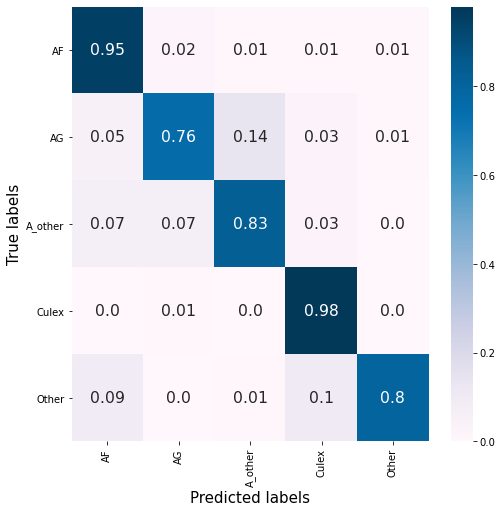

In [ ]:
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
species_all = ["AF",
        "AG",
        "A_other",
        "Culex",
        "Other"]
# print classification report
print(classification_report(test_label, out))

# make confusion matrix
conf_mat = confusion_matrix(test_label, out)
conf_mat = conf_mat / np.expand_dims(conf_mat.astype(np.float64).sum(axis=1),1)
conf_mat = np.round(conf_mat, decimals=2)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
hm = sn.heatmap(conf_mat, annot=True, ax = ax, cmap="PuBu", fmt='.2', annot_kws={"size": 35 / np.sqrt(len(conf_mat))})
ax.set_yticklabels(hm.get_yticklabels(), rotation=90)
ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
ax.xaxis.set_ticklabels(species_all); ax.yaxis.set_ticklabels(species_all)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.savefig('species/figures/Species_Inception_test_3_with_augmentation.jpg')
plt.show();


In [ ]:
torch.save(model.state_dict(), \
               'species/models/Species_Inception_fold2_3_with_augmentation.pt')

In [ ]:
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile
model = models.inception_v3(pretrained=False)
model.fc = nn.Linear(2048, 5)
model.AuxLogits.fc = nn.Linear(768, 5)
model.load_state_dict(torch.load("species/models/Species_Inception_fold2_3_with_augmentation.pt"))
model.eval()

example = torch.rand(1, 3, 299, 299)
traced_script_module = torch.jit.trace(model, example)
optimized_scripted_module = optimize_for_mobile(traced_script_module)
#torch.jit.save(optimized_scripted_module, '../models/model.pt')
optimized_scripted_module._save_for_lite_interpreter("species/models/Species_Inception_3_with_augmentation.ptl")

D:\anaconda3\lib\site-packages\torchvision\models\inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
